In [12]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from redist import modifier
from redist import plot
from ksnunu_utils import * 

# Reinterpreting $B \to K^* \nu \nu$ in terms of the WET

Here the differential branching ratio prediction is a function of one kinematic variable: $q^2$.

We use $q^2$ also as the fitting variable, but with a different binning than for the reweighting.

## Define the binning

In [13]:
binning = np.linspace(0.0, 19.25, 11) 
bin_cents = (binning[:-1] + binning[1:])/2
q2binning = np.linspace(0.0, 19.25, 20)

## Define the NP model in WC space

In [14]:
cvl = 5.0
cvr = 1.0
csl = 1.0
csr = 1.0
ctl = 1.0

## Generate some SM samples

In [15]:
SMsamples = int(2e6) # factor 2 because BR(K*nunu) ~ 2*BR(Knunu)

p = analysis().parameters
k = eos.Kinematics(q2=1.0, q2_min=0.0, q2_max=19.25)
o = eos.Options(**{'form-factors': 'BSZ2015', 'model': 'WET'})

pdf = eos.SignalPDF.make('B^-->K^*-nunu::dGamma/dq2', p, k, o)
obs = eos.Observable.make('B->K^*nunu::BR', p, k, o)
SMBR = obs.evaluate()

null_samples, pdf_values = pdf.sample_mcmc(SMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=1230))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [16]:
np.random.seed(4560)
null_samples_smeared = np.random.normal(null_samples, 1.0, null_samples.shape)
null_samples_smeared = np.abs(null_samples_smeared)

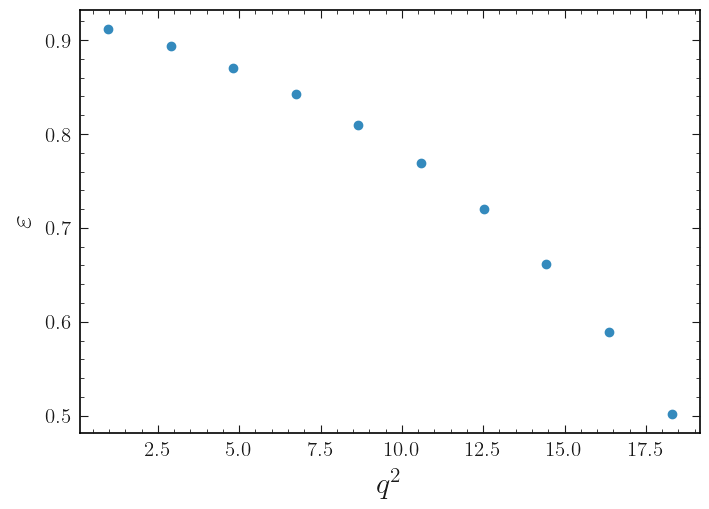

In [17]:
plt.plot(bin_cents, efficiency(bin_cents), "o")

plt.xlabel(r'$q^2$')
plt.ylabel(r'$\varepsilon$')
plt.show()

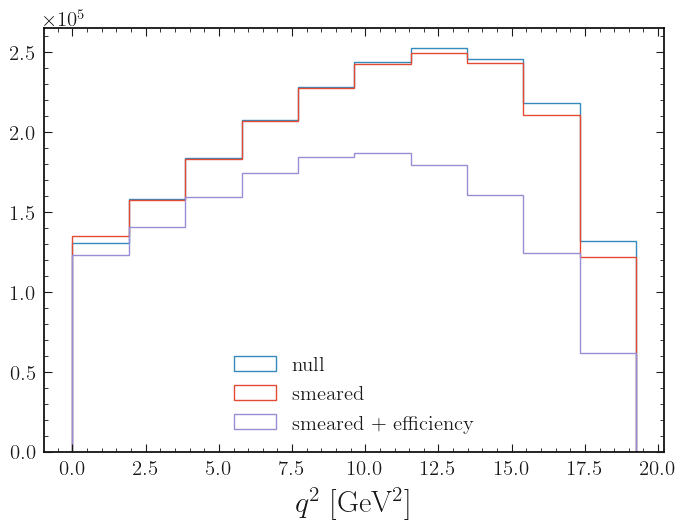

In [18]:
plt.hist(null_samples, binning, histtype='step', label='null')
plt.hist(null_samples_smeared, binning, histtype='step', label='smeared')
null_yields, _, _ = plt.hist(null_samples_smeared, binning, weights = efficiency(null_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Generate some fake data according to some NP model

Need to scale the number of samples here, because if NP would exist, we would also see a total different count of events.

In [19]:
p['sbnunu::Re{cVL}'].set(cvl)
p['sbnunu::Re{cVR}'].set(cvr)
p['sbnunu::Re{cSL}'].set(csl)
p['sbnunu::Re{cSR}'].set(csr)
p['sbnunu::Re{cTL}'].set(ctl)

BSMBR = obs.evaluate()

BSMsamples = int(SMsamples*BSMBR/SMBR)
alt_samples, pdf_values = pdf.sample_mcmc(BSMsamples, stride=5, pre_N=10000, preruns=5, cov_scale=0.1, rng=np.random.mtrand.RandomState(seed=7890))

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

### Smear samples with Gaussian resolution function and apply efficiency


In [20]:
np.random.seed(1010)
alt_samples_smeared = np.random.normal(alt_samples, 1.0, alt_samples.shape)
alt_samples_smeared = np.abs(alt_samples_smeared)

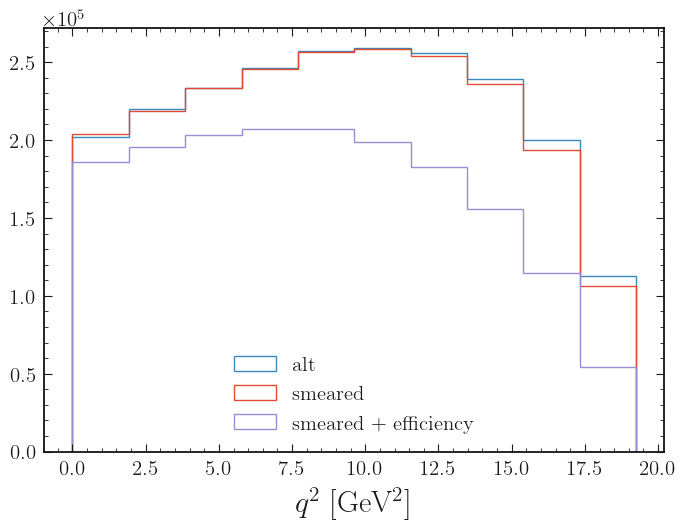

In [21]:
plt.hist(alt_samples, binning, histtype='step', label='alt')
plt.hist(alt_samples_smeared, binning, histtype='step', label='smeared')
alt_yields, _, _ = plt.hist(alt_samples_smeared, binning, weights = efficiency(alt_samples_smeared), histtype='step', label='smeared + efficiency')

plt.xlabel(r'$q^2$ [GeV$^2$]')
plt.legend()

## Set up the mapping distribution

In [22]:
mapping_dist = modifier.map(null_samples_smeared.flatten(), [null_samples.flatten()], binning, [q2binning])
mapping_dist = mapping_dist * efficiency(bin_cents)[:,np.newaxis]

## Set up the custom modifier

In [23]:
null = null_pred()
alt = alt_pred()

In [24]:
ana  = analysis()

v0   = ana.parameters['B->K^*::alpha^V_0@BSZ2015'  ].evaluate()
v1   = ana.parameters['B->K^*::alpha^V_1@BSZ2015'  ].evaluate()
v2   = ana.parameters['B->K^*::alpha^V_2@BSZ2015'  ].evaluate()
a00  = ana.parameters['B->K^*::alpha^A0_0@BSZ2015' ].evaluate() 
a01  = ana.parameters['B->K^*::alpha^A0_1@BSZ2015' ].evaluate() 
a02  = ana.parameters['B->K^*::alpha^A0_2@BSZ2015' ].evaluate()
a10  = ana.parameters['B->K^*::alpha^A1_0@BSZ2015' ].evaluate()
a11  = ana.parameters['B->K^*::alpha^A1_1@BSZ2015' ].evaluate()
a12  = ana.parameters['B->K^*::alpha^A1_2@BSZ2015' ].evaluate()
a121 = ana.parameters['B->K^*::alpha^A12_1@BSZ2015'].evaluate()
a122 = ana.parameters['B->K^*::alpha^A12_2@BSZ2015'].evaluate()
t10  = ana.parameters['B->K^*::alpha^T1_0@BSZ2015' ].evaluate()
t11  = ana.parameters['B->K^*::alpha^T1_1@BSZ2015' ].evaluate()
t12  = ana.parameters['B->K^*::alpha^T1_2@BSZ2015' ].evaluate()
t21  = ana.parameters['B->K^*::alpha^T2_1@BSZ2015' ].evaluate()
t22  = ana.parameters['B->K^*::alpha^T2_2@BSZ2015' ].evaluate()
t230 = ana.parameters['B->K^*::alpha^T23_0@BSZ2015'].evaluate()
t231 = ana.parameters['B->K^*::alpha^T23_1@BSZ2015'].evaluate()
t232 = ana.parameters['B->K^*::alpha^T23_2@BSZ2015'].evaluate()

In [25]:
# Get covariance matrix of hadronic parameters
cov = parameter_cov(alt.ana, chains = 5, samples = 10000)
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

Pre-runs:   0%|          | 0/5 [00:00<?, ?it/s]

Main run:   0%|          | 0/100 [00:00<?, ?it/s]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000496,0.000170,-0.012269,0.000162,0.000365,-0.000900,0.002674,0.004422,0.000112,-0.000338,0.001091,0.000091,-0.000031,-0.001049,0.000357,0.000203,0.000166,0.000580,-0.000644
1,0.000170,0.029694,0.089715,-0.000040,0.002578,-0.002977,0.009469,0.037270,-0.000262,0.002831,-0.029321,-0.000163,0.000135,0.004835,-0.001036,-0.002803,-0.000400,-0.000057,0.009558
2,-0.012269,0.089715,2.338863,-0.000908,-0.011460,0.105152,-0.074998,0.086737,0.000552,-0.016807,0.248802,0.000562,-0.001207,-0.028987,0.002641,-0.015255,-0.002524,-0.002429,0.071072
3,0.000162,-0.000040,-0.000908,0.000229,0.000632,-0.002689,0.000713,0.001677,0.000248,-0.000096,-0.005174,0.000195,0.000042,-0.002805,0.000877,0.000335,0.000219,0.000837,0.000778
4,0.000365,0.002578,-0.011460,0.000632,0.011066,0.035157,0.013463,0.076331,0.000916,0.001880,-0.044458,0.000735,0.000283,-0.010544,0.003594,0.003224,0.000767,0.003008,0.004825
5,-0.000900,-0.002977,0.105152,-0.002689,0.035157,0.405435,0.042048,0.348329,-0.001107,-0.005189,0.102336,-0.000989,-0.001455,0.012863,-0.002987,0.014271,-0.001015,-0.008910,-0.025907
6,0.002674,0.009469,-0.074998,0.000713,0.013463,0.042048,0.077593,0.436575,0.000331,0.002494,-0.032327,0.000348,-0.000272,-0.001228,0.001699,0.002011,0.000554,0.002602,0.003339
7,0.004422,0.037270,0.086737,0.001677,0.076331,0.348329,0.436575,2.999522,0.000982,0.012465,-0.102225,0.001105,-0.002301,-0.000414,0.007297,0.013450,0.000587,0.005758,0.048128
8,0.000112,-0.000262,0.000552,0.000248,0.000916,-0.001107,0.000331,0.000982,0.000530,-0.000858,-0.022202,0.000268,0.000042,-0.003637,0.001208,0.000505,0.000305,0.001034,-0.000182
9,-0.000338,0.002831,-0.016807,-0.000096,0.001880,-0.005189,0.002494,0.012465,-0.000858,0.021821,0.069352,-0.000045,0.000349,-0.001173,0.000129,0.000209,-0.000326,0.000461,0.015776


In [26]:
cvlSM = eos.Parameters()['sbnunu::Re{cVL}'].evaluate()

new_params = {
                'cvl'   :{'inits': (cvlSM,), 'bounds': ((3., 9.),), 'paramset_type': 'unconstrained'},
                'cvr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'csr'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'ctl'   :{'inits': (0.01, ), 'bounds': ((0., 6.),), 'paramset_type': 'unconstrained'},
                'FFKs'    :{'inits': (v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232), 
                         'bounds': (), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, [q2binning.tolist()], name='ksnunu')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 700x500 with 1 Axes>,
 <Axes: xlabel='$q^2$ [GeV$^2$]', ylabel='$d\\mathcal{B}/dq^2$'>)

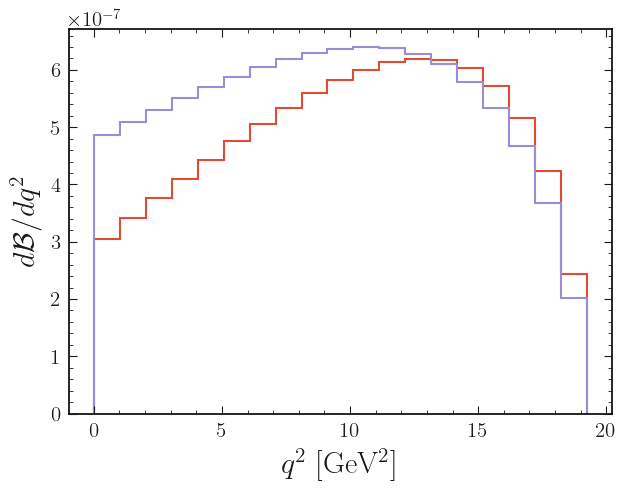

In [27]:
pars = (cvl, cvr, csl, csr, ctl, v0, v1, v2, a00, a01, a02, a10, a11, a12, a121, a122, t10, t11, t12, t21, t22, t230, t231, t232)
lims = [0.0, 19.25]
labels = [r'$q^2$ [GeV$^2$]', r'$d\mathcal{B}/dq^2$']
plot.dists(cmod, pars, lims, labels)

(<Figure size 800x550 with 2 Axes>,
 <Axes: xlabel='Kinematic bins', ylabel='Fitting bins'>)

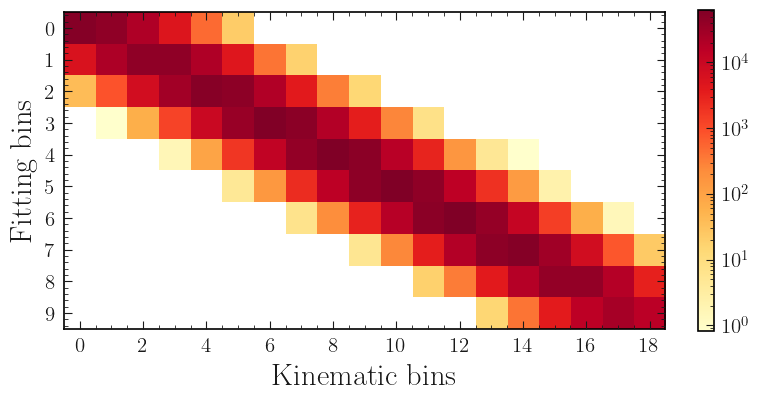

In [28]:
plot.map(cmod, cmap='YlOrRd', norm=LogNorm())

## Set up the model

In [29]:
spec = {
  "channels": [
    {
      "name": "B->K*nunu",
      "samples": [
        {
          "name": "signal",
          "data": null_yields.tolist(),
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            },
            {
                "name": "stat",
                "type": "staterror",
                "data": np.sqrt(null_yields).tolist()
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "ksnunu_theory",
                "type": "ksnunu",
                "data":
                    {"expr": "ksnunu_weight_fn"}
              }

model = modifier.add_to_model(model, ['B->K*nunu'], ['signal'], cmod.expanded_pyhf, custom_mod)
model.spec

{'channels': [{'name': 'B->K*nunu',
   'samples': [{'name': 'signal',
     'data': [123139.36785983796,
      140619.74523465242,
      159474.3227360585,
      174528.51665539597,
      184345.1787704263,
      186616.31252148212,
      179578.159102396,
      160776.1698509818,
      124260.33284340473,
      61842.27413556329],
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'stat',
       'type': 'staterror',
       'data': [350.9121939457761,
        374.99299358075,
        399.3423628117339,
        417.76610280801384,
        429.35437434644393,
        431.9911023637896,
        423.7666328327373,
        400.9690385191627,
        352.5057912196688,
        248.68106911376123]},
      {'name': 'ksnunu_theory',
       'type': 'ksnunu',
       'data': {'expr': 'ksnunu_weight_fn'}}]}]}]}

## Save and load model

In [30]:
modifier.save('ksnunu_model.json', model.spec, cmod, alt_yields)
model, alt_yields = modifier.load('ksnunu_model.json', alt.distribution, null.distribution, return_data=True)

data = alt_yields + model.config.auxdata

## Perform the fit

In [31]:
fixed = model.config.suggested_fixed()
fixed[model.config.par_map['mu']['slice']] = [True]
# fixed[model.config.par_map['cvr']['slice']] = [True]
fixed[model.config.par_map['csr']['slice']] = [True]

for i in range(3, 19):
    fixed[model.config.par_map[f'FFKs_decorrelated[{i}]']['slice']] = [True]


pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2))
best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
    data,
    model,
    init_pars=best_fit.tolist(),
    fixed_params=fixed,
    return_uncertainties=True,
    return_fitted_val=True,
    return_result_obj=True
    )

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict


W MnPosDef Matrix forced pos-def by adding to diagonal 0.00646697
W MnPosDef Matrix forced pos-def by adding to diagonal 0.00598538
W MnPosDef Matrix forced pos-def by adding to diagonal 0.550823


{'cvl': array([4.98872766, 0.0143032 ]),
 'cvr': array([0.92825797, 0.02110458]),
 'csl': array([0.00445085, 3.64966462]),
 'csr': array([0.01, 0.  ]),
 'ctl': array([0.99652105, 0.00132386]),
 'FFKs_decorrelated[0]': array([0.06863143, 0.51663507]),
 'FFKs_decorrelated[1]': array([0.05423097, 0.02568801]),
 'FFKs_decorrelated[2]': array([-0.06820615,  0.04011327]),
 'FFKs_decorrelated[3]': array([0., 0.]),
 'FFKs_decorrelated[4]': array([0., 0.]),
 'FFKs_decorrelated[5]': array([0., 0.]),
 'FFKs_decorrelated[6]': array([0., 0.]),
 'FFKs_decorrelated[7]': array([0., 0.]),
 'FFKs_decorrelated[8]': array([0., 0.]),
 'FFKs_decorrelated[9]': array([0., 0.]),
 'FFKs_decorrelated[10]': array([0., 0.]),
 'FFKs_decorrelated[11]': array([0., 0.]),
 'FFKs_decorrelated[12]': array([0., 0.]),
 'FFKs_decorrelated[13]': array([0., 0.]),
 'FFKs_decorrelated[14]': array([0., 0.]),
 'FFKs_decorrelated[15]': array([0., 0.]),
 'FFKs_decorrelated[16]': array([0., 0.]),
 'FFKs_decorrelated[17]': array([0.,

In [32]:
best_fit_rot = cmod.rotate_pars({k:v[0] if len(np.shape(v))==1 else [p[0] for p in v] for k, v in best_fit_dict.items()})
best_fit_rot

{'cvl': 4.988727659007602,
 'cvr': 0.92825797246352,
 'csl': 0.004450846974883866,
 'csr': 0.01,
 'ctl': 0.9965210471667625,
 'FFKs[0]': 0.3626772477954349,
 'FFKs[1]': -1.0884122767240592,
 'FFKs[2]': 2.8578858200847566,
 'FFKs[3]': 0.34190303654432663,
 'FFKs[4]': -1.1484900529328739,
 'FFKs[5]': 2.3846622120021146,
 'FFKs[6]': 0.2922593216354926,
 'FFKs[7]': 0.497282017820582,
 'FFKs[8]': 1.2231263016673244,
 'FFKs[9]': 0.5547485502046481,
 'FFKs[10]': 0.7294918763189524,
 'FFKs[11]': 0.3189679465356313,
 'FFKs[12]': -0.9622677224635913,
 'FFKs[13]': 2.104105970874639,
 'FFKs[14]': 0.591689494014396,
 'FFKs[15]': 1.6810289365086746,
 'FFKs[16]': 0.6202480696945746,
 'FFKs[17]': 0.9826371667678832,
 'FFKs[18]': 1.950963061030839,
 'mu': 1.0,
 'stat': [0.9986818574482743,
  1.001534239417381,
  1.0007213298643292,
  0.9988848399766248,
  1.0006648698972391,
  0.9989997932705512,
  1.0000426323944644,
  1.0003712385290744,
  1.0006140459087534,
  0.9990940235452453]}

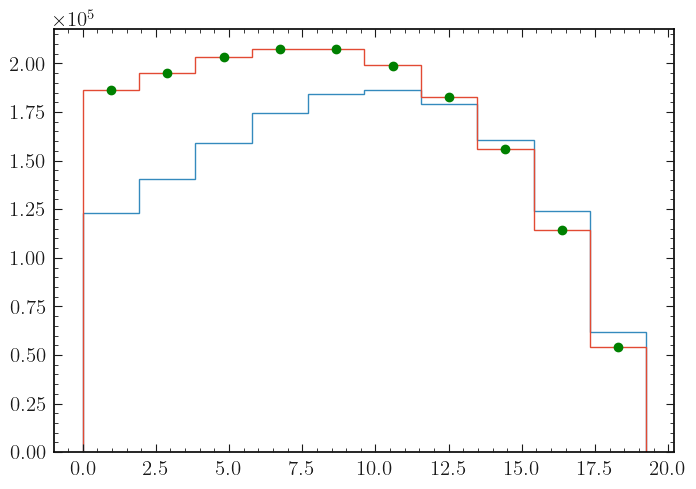

In [33]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit[:,0]), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, alt_yields, 'og')